# Training: Creating tiles from microscopy images
### Kaggle Competition: UBC Ovarian Cancer Subtype Classification and Outlier Detection (UBC-OCEAN)

The training and validation data are the tiles extracted from the original images, using the "Preprocessing_create_tiles" script.

Some notes: 
- This should be run on a Kaggle kernel with GPU.
- Some data augmentation (Random Rotation, Random Color Jitter) is used to extend training data

Model:
- Pretrained tf_efficientnet_b0_ns.
- added a 3rd order GeM pooling layer, which improves the results substantially.
- Whole network is trained (no freezed layers)
- Balanced accuracy on public test data is 0.38 (currently top 30 %)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import time

import pytorch_lightning as pl

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import timm

import torch
from torch import optim 
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split
#

CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 2048,
    "model_name": "tf_efficientnet_b0_ns",
    "pretrained": True,
    "num_classes": 5,
    "train_batch_size": 20,
    "valid_batch_size": 20,
    "train_test_split": 0.8,
    "learning_rate": 5e-6,
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 10,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

# First, we create a dataset (pandas dataframe) for the training data

In [3]:
tiles_per_image = 100
img_dir_1 = '/kaggle/input/create-patches-v3-1/tiles/'
img_dir_2 = '/kaggle/input/create-patches-v3-2/tiles/'
img_dir_3 = '/kaggle/input/create-patches-v3-3/tiles/'

df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')

fpaths = []
labels = []
image_ids = []

for fname in os.listdir(img_dir_1):
    image_id = int(fname.split('_')[0])
    label = df[df['image_id']==image_id]
    labels.append(label.iloc[0][1])
    fpaths.append(os.path.join(img_dir_1, fname))
    image_ids.append(image_id)
    
for fname in os.listdir(img_dir_2):
    image_id = int(fname.split('_')[0])
    label = df[df['image_id']==image_id]
    labels.append(label.iloc[0][1])
    fpaths.append(os.path.join(img_dir_2, fname))
    image_ids.append(image_id)
    
for fname in os.listdir(img_dir_3):
    image_id = int(fname.split('_')[0])
    label = df[df['image_id']==image_id]
    labels.append(label.iloc[0][1])
    fpaths.append(os.path.join(img_dir_3, fname))
    image_ids.append(image_id)
    
df_tiles = pd.DataFrame({'image_id':image_ids, 'label':labels, 'fpath':fpaths})
df_tiles.head()

df_tiles['tile_number'] = [int(f.split('.')[0].split('_')[1]) for f in fpaths]
df_tiles = df_tiles[df_tiles['tile_number']<tiles_per_image]
len(df_tiles)

/tmp/ipykernel_26/1426810254.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(label.iloc[0][1])
/tmp/ipykernel_26/1426810254.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(label.iloc[0][1])
/tmp/ipykernel_26/1426810254.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(label.iloc[0][1])


26645

In [4]:
# One Hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
labels = df['label']
l_encoder = LabelEncoder()
l_encoded = l_encoder.fit_transform(labels)

oh_encoder = OneHotEncoder(sparse_output=False)
l_encoded = l_encoded.reshape(len(l_encoded), 1)
oh_encoded = oh_encoder.fit_transform(l_encoded)

def oh_encoding(label):
    l_encoded = l_encoder.transform(label)
    l_encoded = l_encoded.reshape(len(l_encoded), 1)
    oh_encoded = oh_encoder.transform(l_encoded)
    #print(label, l_encoded, oh_encoded)

    return torch.from_numpy(oh_encoded)

def oh_encoding_inv(output_tensor):
    a = torch.max(output.data, 1)[1]
    return list(l_encoder.inverse_transform(a))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [5]:
class TileDataSet(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):    
        image_id = self.df.iloc[idx].iloc[0]
        label = self.df.iloc[idx].iloc[1]
        image_path = self.df.iloc[idx].iloc[2]

        im = Image.open(image_path)
        im = self.transform(im)
        return im, label

In [6]:
from torchvision import transforms
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

# Training transform, includes some augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation((0, 360)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
# Create train-validation split, define dataloaders


batch_size = CONFIG['train_batch_size']
train_size = CONFIG['train_test_split']

train_df_temp, val_df_temp = train_test_split(df, train_size=train_size, random_state=2, 
                                    stratify=df['label'])

train_df = df_tiles[df_tiles['image_id'].isin(list(train_df_temp['image_id']))]
val_df = df_tiles[df_tiles['image_id'].isin(list(val_df_temp['image_id']))]



train_dataset = TileDataSet(train_df, transform=train_transform)
val_dataset = TileDataSet(val_df, transform=val_transform)


train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                shuffle=True)

val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False)

In [7]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [8]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'], CONFIG['pretrained'])
model.to(CONFIG['device']);
torch.save(model, 'model_initial_weights.pt')

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


In [1]:
# Create loss function (criterion) and optimizer

from sklearn.utils import class_weight
classes = np.unique(df_tiles['label'])
class_weights=class_weight.compute_class_weight('balanced',
                                                classes = classes,
                                                y = np.array(df_tiles['label']))

def get_class_weight(label):
    i = np.argmax(classes==label)
    return class_weights[i]

sample_weights = train_df['label'].apply(get_class_weight)


class_weights = torch.tensor(class_weights)
if torch.cuda.is_available(): 
    class_weights = class_weights.cuda()
    
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])

NameError: name 'np' is not defined

In [9]:
# Training loop

model.train()

df_metrics = {'val_accuracy':[], 'train_accuracy':[], 
              'val_balanced_accuracy':[], 'train_balanced_accuracy':[],
              'val_loss':[], 'train_loss':[]}

num_epochs = 50
for epoch in tqdm(range(1, num_epochs+1)):
    print()
    print(f'Epoch {epoch}...')
    ######## Training ########
    model.train()
    y_pred = []
    y_true = []
    losses = []
    for i, data in tqdm(enumerate(train_dataloader), 
            total=len(train_dataloader.dataset)/batch_size+1):
        image, label = data

        img, label = data
        label_oh = oh_encoding(label)
        if torch.cuda.is_available(): 
            img = img.to(device='cuda')
            label_oh = label_oh.to(device='cuda')

        #img = img.to(device='cuda')
        output = model(img)

        loss = criterion(output, label_oh)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        output = output.to('cpu')
        output = oh_encoding_inv(output)
        y_pred.append(output)
        y_true.append(list(label))
        losses.append(float(loss.data.to('cpu')))

    y_pred = [label for batch in y_pred for label in batch]
    y_true = [label for batch in y_true for label in batch]

    df_metrics['train_accuracy'].append(accuracy_score(y_true, y_pred))
    df_metrics['train_balanced_accuracy'].append(balanced_accuracy_score(y_true, y_pred))
    df_metrics['train_loss'].append(np.mean(losses))


    ###### Validation ##########
    print('Validation')
    model.eval()
    y_pred = []
    y_true = []
    losses = []
    for i, data in tqdm(enumerate(val_dataloader), 
                        total=len(val_dataloader.dataset)/batch_size+1):
        img, label = data
        img = img.to(device='cuda')
        output = model(img)

        label_oh = oh_encoding(label)
        label_oh = label_oh.to(device='cuda')

        loss = criterion(output, label_oh)
        torch.cuda.empty_cache()


        output = output.to('cpu')
        output = oh_encoding_inv(output)

        y_pred.append(output)
        y_true.append(list(label))
        losses.append(float(loss.data.to(device='cpu')))

    # Flatten lists and compute metrics
    y_pred = [label for batch in y_pred for label in batch]
    y_true = [label for batch in y_true for label in batch]
    df_metrics['val_accuracy'].append(accuracy_score(y_true, y_pred))
    df_metrics['val_balanced_accuracy'].append(balanced_accuracy_score(y_true, y_pred))
    df_metrics['val_loss'].append(np.mean(losses))

    for key in df_metrics:
        print(key, round(df_metrics[key][-1],3))

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'state_dict_epoch_{epoch}.pt')

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.323
train_accuracy 0.298
val_balanced_accuracy 0.391
train_balanced_accuracy 0.315
val_loss 1.388
train_loss 1.561

Epoch 2...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.392
train_accuracy 0.435
val_balanced_accuracy 0.49
train_balanced_accuracy 0.468
val_loss 1.253
train_loss 1.344

Epoch 3...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.428
train_accuracy 0.496
val_balanced_accuracy 0.542
train_balanced_accuracy 0.539
val_loss 1.148
train_loss 1.2

Epoch 4...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.51
train_accuracy 0.533
val_balanced_accuracy 0.579
train_balanced_accuracy 0.583
val_loss 1.039
train_loss 1.089

Epoch 5...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.514
train_accuracy 0.569
val_balanced_accuracy 0.599
train_balanced_accuracy 0.623
val_loss 1.005
train_loss 1.002

Epoch 6...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.568
train_accuracy 0.591
val_balanced_accuracy 0.617
train_balanced_accuracy 0.645
val_loss 0.961
train_loss 0.943

Epoch 7...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.55
train_accuracy 0.609
val_balanced_accuracy 0.618
train_balanced_accuracy 0.661
val_loss 0.944
train_loss 0.888

Epoch 8...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.582
train_accuracy 0.623
val_balanced_accuracy 0.623
train_balanced_accuracy 0.677
val_loss 0.955
train_loss 0.848

Epoch 9...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.582
train_accuracy 0.647
val_balanced_accuracy 0.63
train_balanced_accuracy 0.698
val_loss 0.95
train_loss 0.804

Epoch 10...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.587
train_accuracy 0.653
val_balanced_accuracy 0.638
train_balanced_accuracy 0.707
val_loss 0.944
train_loss 0.777

Epoch 11...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.597
train_accuracy 0.666
val_balanced_accuracy 0.647
train_balanced_accuracy 0.72
val_loss 0.934
train_loss 0.743

Epoch 12...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.57
train_accuracy 0.673
val_balanced_accuracy 0.628
train_balanced_accuracy 0.724
val_loss 0.978
train_loss 0.724

Epoch 13...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.604
train_accuracy 0.683
val_balanced_accuracy 0.647
train_balanced_accuracy 0.736
val_loss 0.971
train_loss 0.704

Epoch 14...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.607
train_accuracy 0.692
val_balanced_accuracy 0.64
train_balanced_accuracy 0.745
val_loss 0.923
train_loss 0.679

Epoch 15...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.599
train_accuracy 0.699
val_balanced_accuracy 0.642
train_balanced_accuracy 0.751
val_loss 0.924
train_loss 0.671

Epoch 16...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.599
train_accuracy 0.711
val_balanced_accuracy 0.639
train_balanced_accuracy 0.763
val_loss 0.946
train_loss 0.643

Epoch 17...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.597
train_accuracy 0.715
val_balanced_accuracy 0.64
train_balanced_accuracy 0.769
val_loss 0.956
train_loss 0.621

Epoch 18...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.589
train_accuracy 0.724
val_balanced_accuracy 0.637
train_balanced_accuracy 0.774
val_loss 0.936
train_loss 0.609

Epoch 19...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.614
train_accuracy 0.727
val_balanced_accuracy 0.637
train_balanced_accuracy 0.776
val_loss 0.96
train_loss 0.59

Epoch 20...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.612
train_accuracy 0.733
val_balanced_accuracy 0.642
train_balanced_accuracy 0.782
val_loss 0.94
train_loss 0.587

Epoch 21...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.6
train_accuracy 0.741
val_balanced_accuracy 0.635
train_balanced_accuracy 0.791
val_loss 0.969
train_loss 0.565

Epoch 22...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.616
train_accuracy 0.743
val_balanced_accuracy 0.643
train_balanced_accuracy 0.793
val_loss 0.973
train_loss 0.554

Epoch 23...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.618
train_accuracy 0.748
val_balanced_accuracy 0.64
train_balanced_accuracy 0.797
val_loss 0.985
train_loss 0.547

Epoch 24...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.626
train_accuracy 0.756
val_balanced_accuracy 0.644
train_balanced_accuracy 0.806
val_loss 0.96
train_loss 0.528

Epoch 25...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.616
train_accuracy 0.759
val_balanced_accuracy 0.644
train_balanced_accuracy 0.807
val_loss 0.965
train_loss 0.518

Epoch 26...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.616
train_accuracy 0.767
val_balanced_accuracy 0.636
train_balanced_accuracy 0.815
val_loss 0.96
train_loss 0.502

Epoch 27...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.615
train_accuracy 0.771
val_balanced_accuracy 0.644
train_balanced_accuracy 0.818
val_loss 0.965
train_loss 0.488

Epoch 28...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.591
train_accuracy 0.77
val_balanced_accuracy 0.632
train_balanced_accuracy 0.815
val_loss 0.991
train_loss 0.496

Epoch 29...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.599
train_accuracy 0.776
val_balanced_accuracy 0.629
train_balanced_accuracy 0.819
val_loss 1.016
train_loss 0.477

Epoch 30...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.621
train_accuracy 0.785
val_balanced_accuracy 0.636
train_balanced_accuracy 0.828
val_loss 1.04
train_loss 0.462

Epoch 31...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.599
train_accuracy 0.788
val_balanced_accuracy 0.64
train_balanced_accuracy 0.833
val_loss 1.006
train_loss 0.456

Epoch 32...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.618
train_accuracy 0.788
val_balanced_accuracy 0.641
train_balanced_accuracy 0.832
val_loss 1.029
train_loss 0.447

Epoch 33...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.622
train_accuracy 0.794
val_balanced_accuracy 0.64
train_balanced_accuracy 0.834
val_loss 1.004
train_loss 0.444

Epoch 34...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.608
train_accuracy 0.798
val_balanced_accuracy 0.645
train_balanced_accuracy 0.841
val_loss 1.027
train_loss 0.432

Epoch 35...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.63
train_accuracy 0.798
val_balanced_accuracy 0.653
train_balanced_accuracy 0.841
val_loss 0.961
train_loss 0.431

Epoch 36...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.614
train_accuracy 0.802
val_balanced_accuracy 0.644
train_balanced_accuracy 0.845
val_loss 1.0
train_loss 0.425

Epoch 37...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.618
train_accuracy 0.803
val_balanced_accuracy 0.641
train_balanced_accuracy 0.845
val_loss 1.029
train_loss 0.415

Epoch 38...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.625
train_accuracy 0.81
val_balanced_accuracy 0.652
train_balanced_accuracy 0.85
val_loss 0.993
train_loss 0.406

Epoch 39...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.619
train_accuracy 0.81
val_balanced_accuracy 0.651
train_balanced_accuracy 0.85
val_loss 1.014
train_loss 0.403

Epoch 40...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.62
train_accuracy 0.814
val_balanced_accuracy 0.639
train_balanced_accuracy 0.853
val_loss 1.031
train_loss 0.399

Epoch 41...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.6
train_accuracy 0.817
val_balanced_accuracy 0.638
train_balanced_accuracy 0.857
val_loss 1.022
train_loss 0.385

Epoch 42...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.618
train_accuracy 0.823
val_balanced_accuracy 0.65
train_balanced_accuracy 0.863
val_loss 1.001
train_loss 0.372

Epoch 43...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.621
train_accuracy 0.822
val_balanced_accuracy 0.652
train_balanced_accuracy 0.861
val_loss 0.984
train_loss 0.376

Epoch 44...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.636
train_accuracy 0.824
val_balanced_accuracy 0.645
train_balanced_accuracy 0.862
val_loss 1.094
train_loss 0.376

Epoch 45...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.613
train_accuracy 0.824
val_balanced_accuracy 0.64
train_balanced_accuracy 0.863
val_loss 1.079
train_loss 0.364

Epoch 46...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.625
train_accuracy 0.829
val_balanced_accuracy 0.651
train_balanced_accuracy 0.865
val_loss 1.05
train_loss 0.366

Epoch 47...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.624
train_accuracy 0.831
val_balanced_accuracy 0.639
train_balanced_accuracy 0.869
val_loss 1.056
train_loss 0.365

Epoch 48...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.637
train_accuracy 0.832
val_balanced_accuracy 0.645
train_balanced_accuracy 0.87
val_loss 1.063
train_loss 0.348

Epoch 49...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.599
train_accuracy 0.838
val_balanced_accuracy 0.613
train_balanced_accuracy 0.875
val_loss 1.193
train_loss 0.344

Epoch 50...


  0%|          | 0/1074.1 [00:00<?, ?it/s]

Validation


  0%|          | 0/260.15 [00:00<?, ?it/s]

val_accuracy 0.611
train_accuracy 0.838
val_balanced_accuracy 0.638
train_balanced_accuracy 0.875
val_loss 1.052
train_loss 0.341


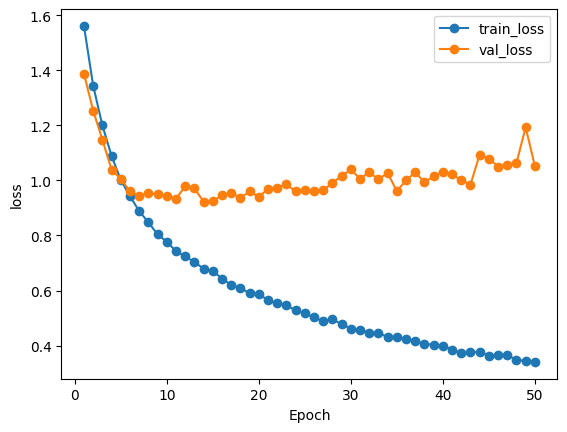

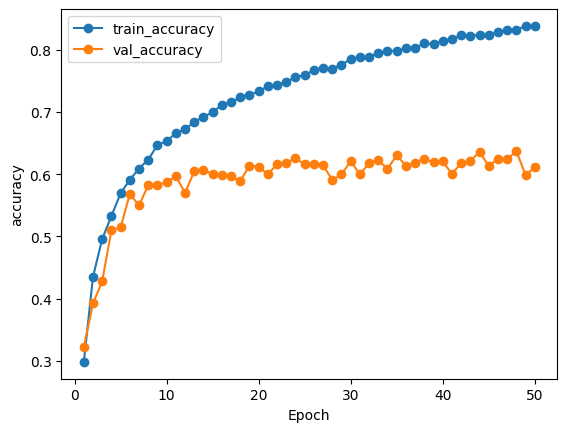

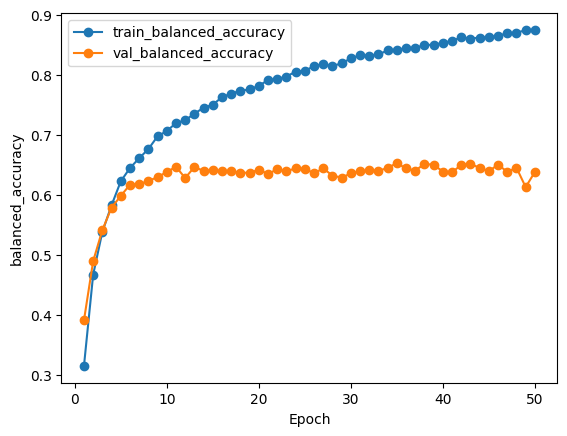

In [10]:
# Plot metrics

key = 'loss'
plt.figure()
for prefix in ['train_', 'val_']:
    plt.plot(np.arange(1, num_epochs+1), df_metrics[prefix+key], 'o-', label=prefix+key)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(key)
plt.savefig('loss.png')


key = 'accuracy'
plt.figure()
for prefix in ['train_', 'val_']:
    plt.plot(np.arange(1, num_epochs+1), df_metrics[prefix+key], 'o-', label=prefix+key)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(key)
plt.savefig('accuracy.png')


key = 'balanced_accuracy'
plt.figure()
for prefix in ['train_', 'val_']:
    plt.plot(np.arange(1, num_epochs+1), df_metrics[prefix+key], 'o-', label=prefix+key)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(key)
plt.savefig('balanced_accuracy.png')